In [1]:
# Import necessary libraries 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Double confirm the correct working directory
os.chdir("C:/Users/sxyse/OneDrive - SIM - Singapore Institute of Management/Documents/2024-2025/programming/programming coursework/programming dataset")  
os.getcwd()

'C:\\Users\\sxyse\\OneDrive - SIM - Singapore Institute of Management\\Documents\\2024-2025\\programming\\programming coursework\\programming dataset'

In [3]:
# Load datasets from 1996 to 2000 manually
files = ["1996.csv", "1997.csv", "1998.csv", "1999.csv", "2000.csv"]
flights_raw = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 27194585 to 14410967
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               5000 non-null   int64  
 1   Month              5000 non-null   int64  
 2   DayofMonth         5000 non-null   int64  
 3   DayOfWeek          5000 non-null   int64  
 4   DepTime            4890 non-null   float64
 5   CRSDepTime         5000 non-null   int64  
 6   ArrTime            4876 non-null   float64
 7   CRSArrTime         5000 non-null   int64  
 8   UniqueCarrier      5000 non-null   object 
 9   FlightNum          5000 non-null   int64  
 10  TailNum            5000 non-null   object 
 11  ActualElapsedTime  4876 non-null   float64
 12  CRSElapsedTime     4992 non-null   float64
 13  AirTime            4876 non-null   float64
 14  ArrDelay           4876 non-null   float64
 15  DepDelay           4890 non-null   float64
 16  Origin            

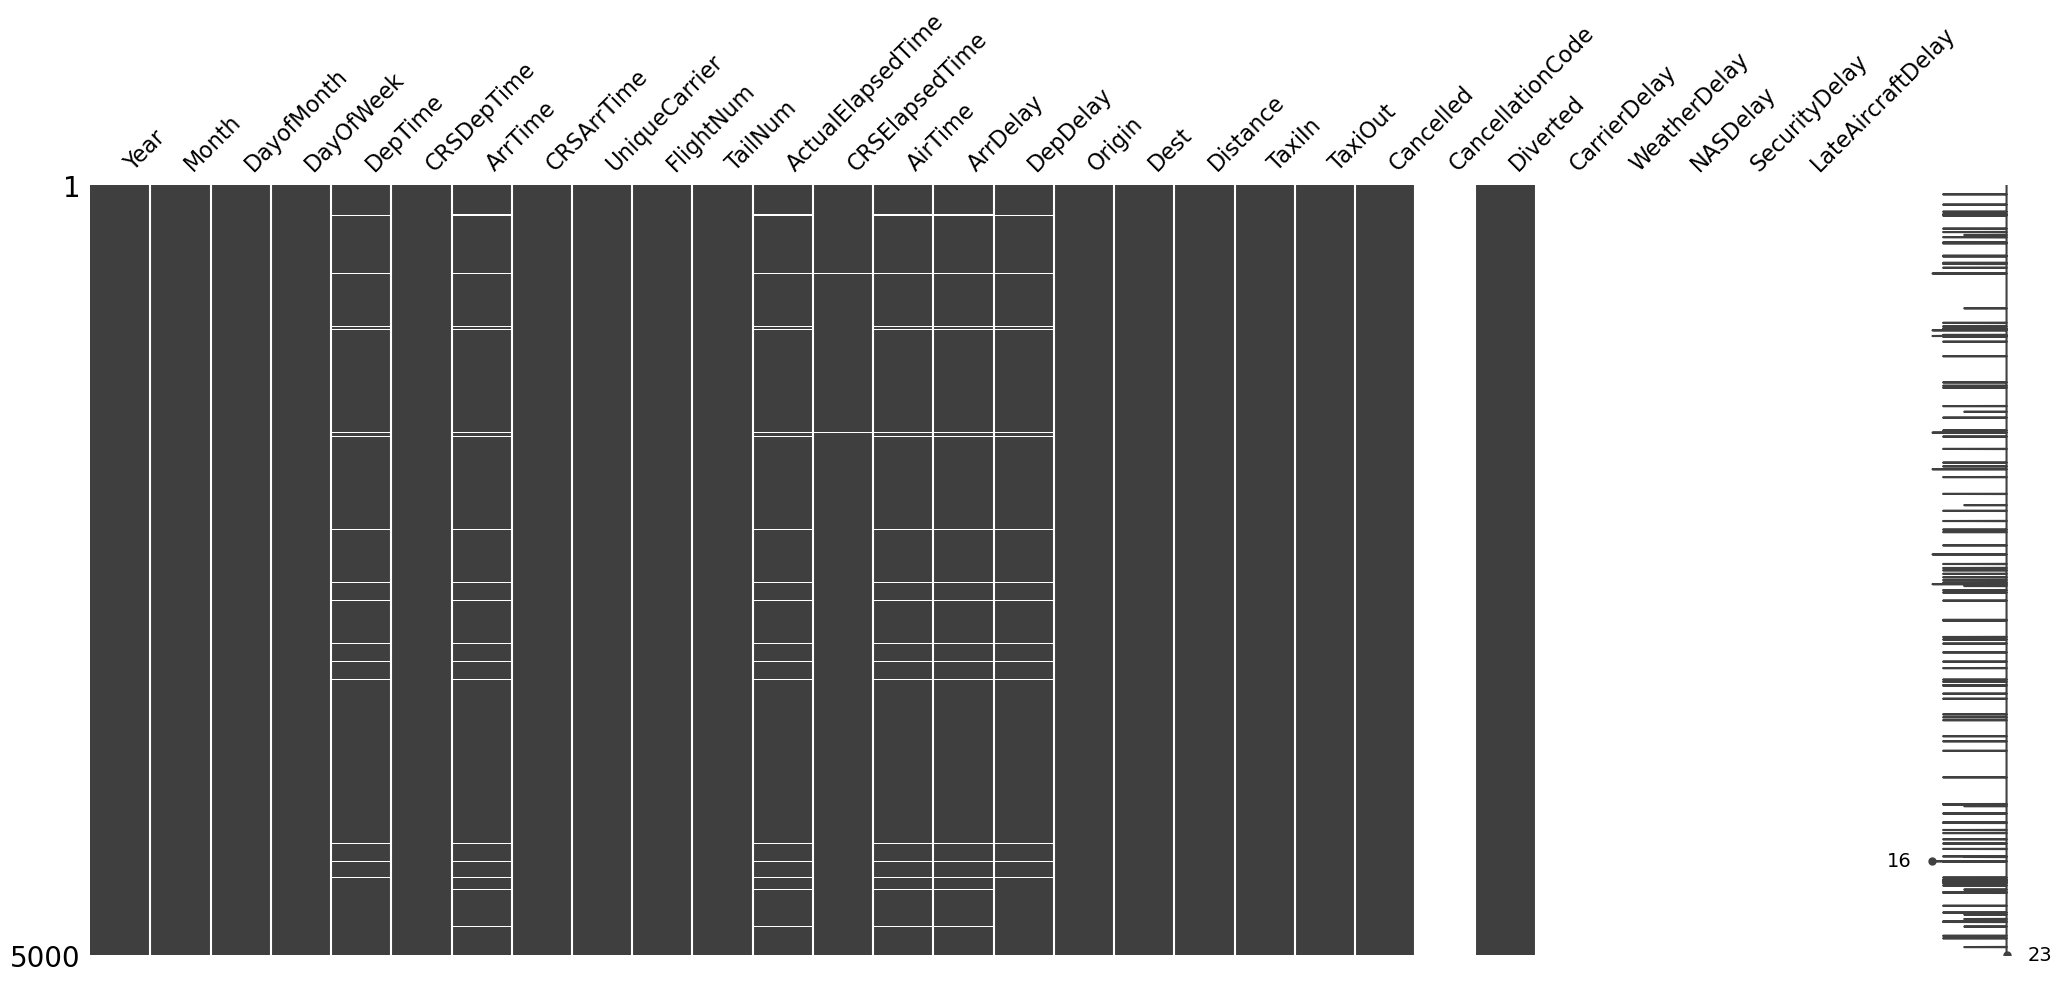

DepTime                2.20
ArrTime                2.48
ActualElapsedTime      2.48
CRSElapsedTime         0.16
AirTime                2.48
ArrDelay               2.48
DepDelay               2.20
CancellationCode     100.00
CarrierDelay         100.00
WeatherDelay         100.00
NASDelay             100.00
SecurityDelay        100.00
LateAircraftDelay    100.00
dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 26579697 entries, 0 to 27359477
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64

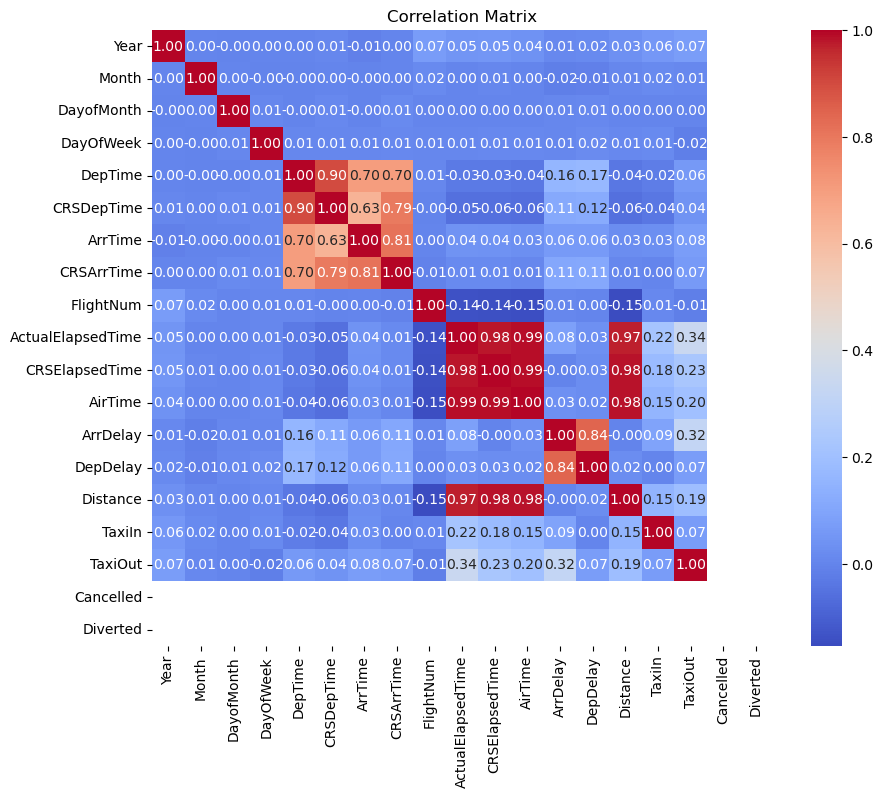

ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day] is missing

In [4]:
# Exploratory Data Analysis (EDA)
# Sample 5the first 5000 rows as it is a very big dataset
flights_eda = flights_raw.sample(n=min(5000, len(flights_raw)), random_state=42)

## Check structure of the dataset
print(flights_eda.info())

## Check the summary statistics for numerical columns
print(flights_eda.describe())

# Data preprocessing: Missing values
## Count missing values in each column
print(flights_eda.isna().sum())

## Visualize the missing values
msno.matrix(flights_eda)
plt.show()

## Print the percentage of missing values per column
missing_percent = flights_eda.isna().mean() * 100
print(missing_percent[missing_percent > 0])

## name all the columns with 100% missing values
cols_all_na = missing_percent[missing_percent == 100].index.tolist()

## Remove rows with NA, ignoring the 100% missing columns
cleaned_flights = flights_raw.drop(columns=cols_all_na).dropna()
print(cleaned_flights.info())

## Select the numerical columns
numeric_cols = cleaned_flights.select_dtypes(include=[np.number])

# Compute the correlation matrix and visualize it
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Convert dates and times
cleaned_flights['DATE'] = pd.to_datetime(cleaned_flights[['Year', 'Month', 'DayofMonth']])
cleaned_flights['DAY_OF_WEEK'] = cleaned_flights['DayOfWeek'].map({1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'})


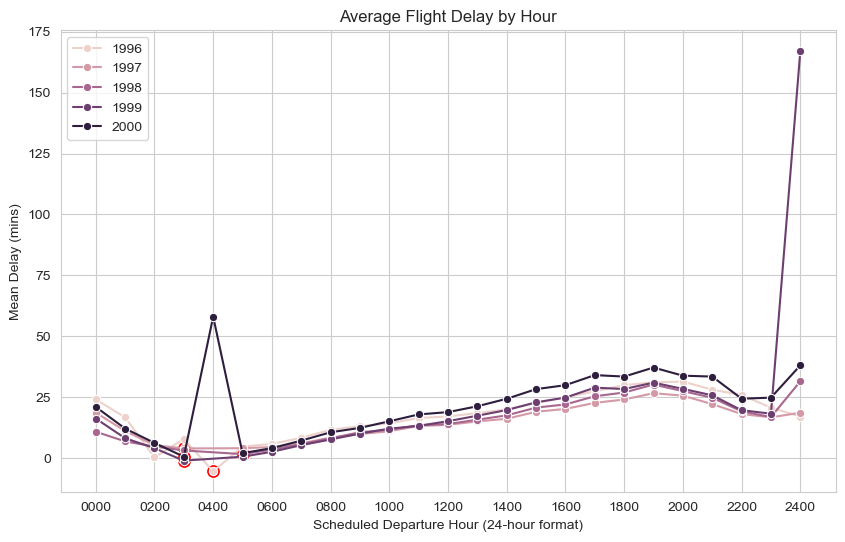

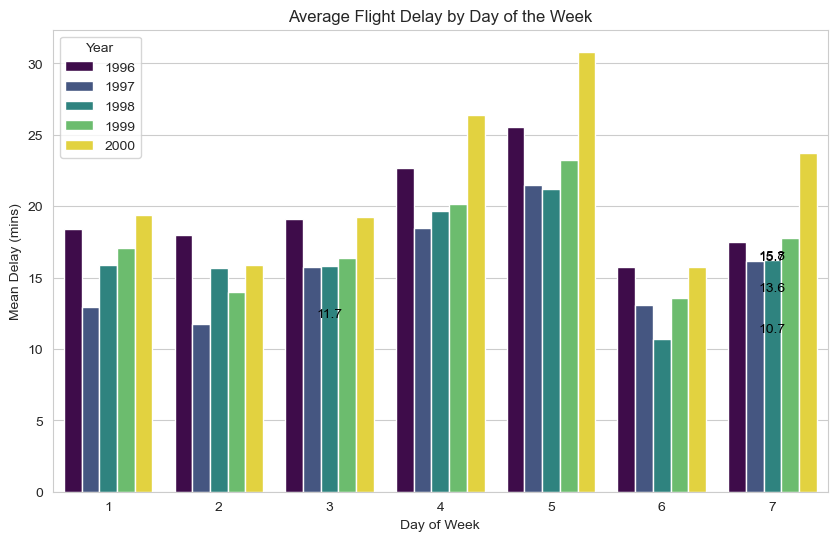

In [36]:
# 1. Best Times and Days to Minimize Delays
cleaned_flights['TOTAL_DELAY'] = cleaned_flights['ArrDelay'] + cleaned_flights['DepDelay']

# Average delay by hour
cleaned_flights['HOUR'] = (cleaned_flights['CRSDepTime'] // 100).astype(int)
hourly_delays = cleaned_flights.groupby(['Year', 'HOUR'])['TOTAL_DELAY'].mean().reset_index()

# Find the minimum delay by hour for each year
min_delays = hourly_delays.loc[hourly_delays.groupby('Year')['TOTAL_DELAY'].idxmin()]

# Plot delays by hour
plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_delays, x='HOUR', y='TOTAL_DELAY', hue='Year', marker='o')
sns.scatterplot(data=min_delays, x='HOUR', y='TOTAL_DELAY', color='red', s=100)
plt.xticks(range(0, 25, 2), labels=[f'{h:02d}00' for h in range(0, 25, 2)])
plt.title('Average Flight Delay by Hour')
plt.xlabel('Scheduled Departure Hour (24-hour format)')
plt.ylabel('Mean Delay (mins)')
plt.show()

# Average delay by day
daily_delays = cleaned_flights.groupby(['Year', 'DayOfWeek'])['TOTAL_DELAY'].mean().reset_index()

# Find the minimum delay for each year across the week
min_weekly_delays = daily_delays.loc[daily_delays.groupby('Year')['TOTAL_DELAY'].idxmin()]

# Plot delays by day
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create bar plot with dodge position
ax = sns.barplot(data=daily_delays, x="DayOfWeek", y="TOTAL_DELAY", hue="Year", dodge=True, palette="viridis")

# Add text labels for the minimum delay values
for _, row in min_weekly_delays.iterrows():
    ax.text(x=row["DayOfWeek"], 
            y=row["TOTAL_DELAY"] + 0.5,  # Slight offset above the bar
            s=round(row["TOTAL_DELAY"], 1), 
            color="black", 
            ha="center")

# Labels and title
plt.title("Average Flight Delay by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Mean Delay (mins)")
plt.legend(title="Year")


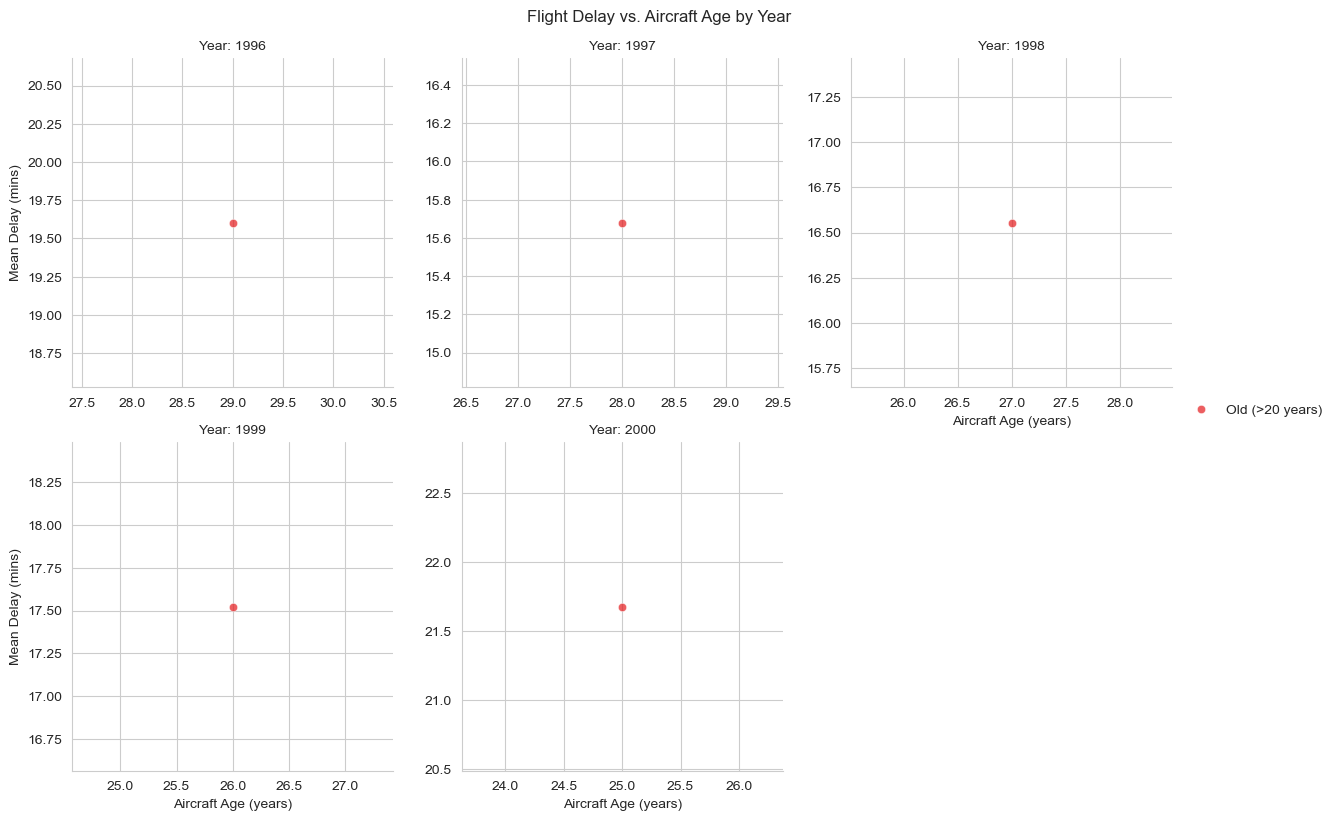

In [38]:
# 2. Do Older Planes Have More Delays?
planes_raw = pd.read_csv("plane-data.csv")
planes = planes_raw.rename(columns={'tailnum': 'TailNum'})
flights_2 = cleaned_flights.merge(planes, on='TailNum', how='left')

# Compute AGE and mean delay
age_delays = (flights_2
              .assign(AGE = 2025 - flights_2['Year'].astype(int))  # Convert Year and compute AGE
              .groupby(['Year', 'AGE'], as_index=False)  # Group by YEAR and AGE
              .agg(Mean_Delay=('TOTAL_DELAY', 'mean'))  # Compute mean delay
             )

# Categorize aircraft age into groups
conditions = [
    age_delays['AGE'] <= 10,
    (age_delays['AGE'] > 10) & (age_delays['AGE'] <= 20),
    age_delays['AGE'] > 20
]
choices = ["Young (0-10 years)", "Medium (11-20 years)", "Old (>20 years)"]
age_delays['Age_Group'] = np.select(conditions, choices, default="Unknown")

# Create scatter plot with regression line and facet by YEAR
g = sns.FacetGrid(age_delays, col="Year", col_wrap=3, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x="AGE", y="Mean_Delay", hue="Age_Group", palette="Set1", alpha=0.7)
g.map_dataframe(sns.regplot, x="AGE", y="Mean_Delay", scatter=False, color="black", ci=None)

# Adjust plot aesthetics
g.set_axis_labels("Aircraft Age (years)", "Mean Delay (mins)")
g.set_titles("Year: {col_name}")
g.add_legend()
plt.suptitle("Flight Delay vs. Aircraft Age by Year", y=1.02)  # Adjust title position
plt.show()

         Current function value: 0.016757
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Diverted   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4980
Method:                           MLE   Df Model:                           19
Date:                Thu, 03 Apr 2025   Pseudo R-squ.:                  0.1297
Time:                        13:34:51   Log-Likelihood:                -83.787
converged:                      False   LL-Null:                       -96.274
Covariance Type:            nonrobust   LLR p-value:                    0.1614
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.6636      1.431     -5.357      0.000     -10.468      -4.859
CRSDepTime          -0.0014      0.002     -0.8

C:\Users\sxyse\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sxyse\AppData\Local\Temp\ipykernel_20692\2859583661.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Variable', y='Coefficient', data=coefs, palette='viridis')


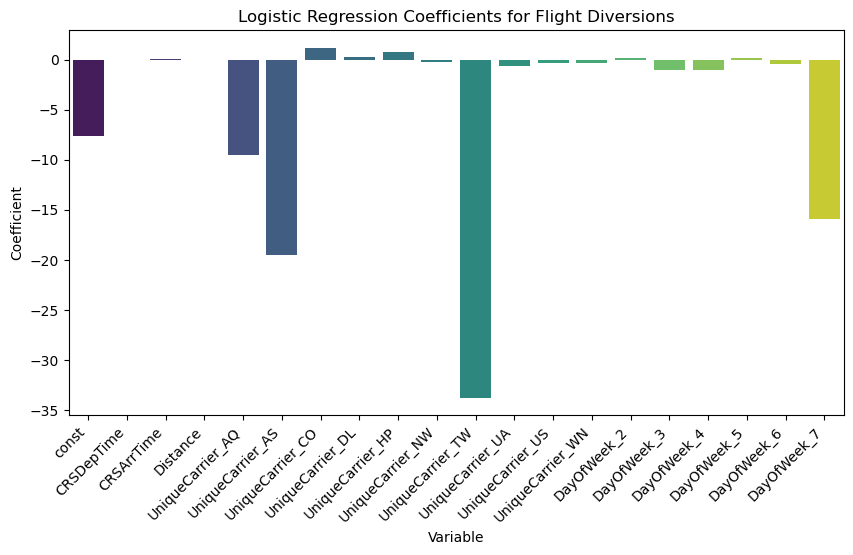

In [26]:
# 3. Logistic Regression for Diverted Flights
# Ensure the variable "Diverted" is numeric 
flights_eda['Diverted'] = flights_eda['Diverted'].astype(int)  

# Selecting relevant columns
flights_3 = flights_eda[['CRSDepTime', 'CRSArrTime', 'Distance', 'UniqueCarrier', 'DayOfWeek', 'Diverted']].dropna()

# Convert categorical variables to dummy variables
flights_3 = pd.get_dummies(flights_3, columns=['UniqueCarrier', 'DayOfWeek'], drop_first=True)
# Check for any 'bool' columns and convert to integers
bool_columns = flights_3.select_dtypes(include='bool').columns
for col in bool_columns:
    flights_3[col] = flights_3[col].astype(int)  # Convert boolean to 0/1

# Define dependent and independent variables
y = y = flights_3['Diverted']
X = flights_3.drop(columns=['Diverted'])
X = sm.add_constant(X)  # Add intercept

# Fit logistic regression model
logistic_model = sm.Logit(y, X).fit()

# Summary of model
print(logistic_model.summary())

# Extract coefficients
coefs = logistic_model.params.reset_index()
coefs.columns = ['Variable', 'Coefficient']

# Visualizing coefficients
plt.figure(figsize=(10, 5))
sns.barplot(x='Variable', y='Coefficient', data=coefs, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Logistic Regression Coefficients for Flight Diversions')
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.show()
